<a href="https://colab.research.google.com/github/jose-zerna/Image-segmentation-Pytorch/blob/main/Image_Segmentation_(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this project
This is a guided project from Coursera: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation  <br>
Original author of the dataset : https://github.com/VikramShenoy97/Human-Segmentation-Dataset


This project consists on performing Image Segmentation to a dataset that contains 300 images of humans with some background and a corresponding binary mask for each of these images. These were the major tasks that the project involved:
-  Understand the Segmentation Dataset and write a custom dataset class for Image-mask dataset.
-  Apply segmentation augmentation to augment images as well as its masks. For image-mask augmentation albumentation library was used.
- Load a pretrained state of the art convolutional neural network for segmentation problem(for e.g, Unet) using segmentation model Pytorch library.
- Create train function and evaluator function for using when writing training loop. Use training loop to train the model.


**Bugs and errors obtained during this project:**
*   `Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency)`. This error was obtained while applying augmentation to the images and masks. I avoided this by adding  `is_check_shapes=False` to avoid shape checking.
*   `Bool value of Tensor with more than one value is ambiguous in Pytorch`: This error was obtained because I missed the parenthesis using the torch.nn.BCEWithLogitsLoss function. I wrote `loss2 = nn.BCEWithLogitsLoss(logits , masks)` instead of `loss2 = nn.BCEWithLogitsLoss()(logits , masks)`.




# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ef7d46ca909b8a9339bae92ff2dc93e098e5820968e42b2eeea054f8bfc8a95e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a47a1b00d2c69f5c6a0fc3cb5307c5d2d382d8e19bf9bbbae0d7f8010f1b59e0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

## Download Dataset

Original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 26.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.


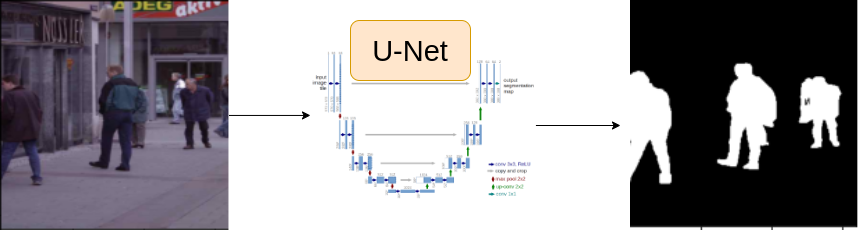

## Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task 2 : Setup Configurations

In [5]:
CSV_FILE ='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head(10)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
5,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
7,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
8,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
9,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [66]:
row = df.iloc[1]

image_path=row.images
mask_path=row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0


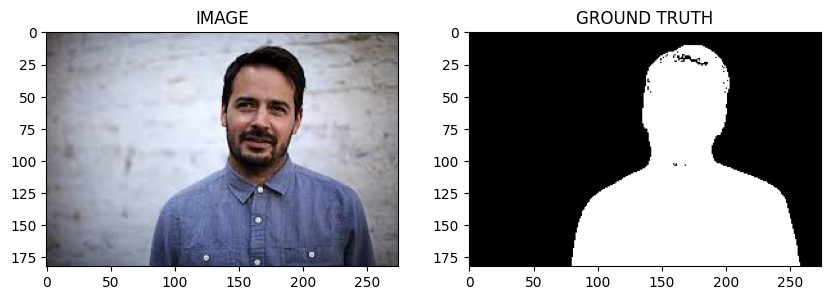

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')
# ax2.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df,test_size = 0.2, random_state = 42)

In [10]:
print(f'Train images: {len(train_df)}, Validation images: {len(valid_df)}')

Train images: 232, Validation images: 58


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p= 0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ],is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset (Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1) # to pass only the last channel

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) # dictionnary holding key as image, and mask as value
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


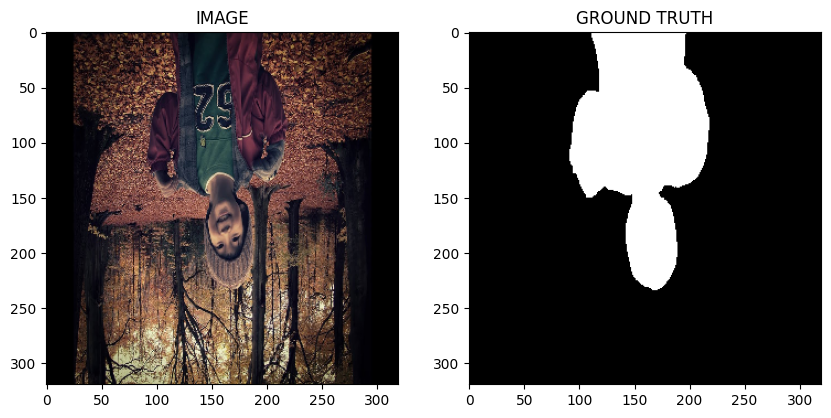

In [17]:
idx = 21
image, mask = trainset[idx]
helper.show_image(image,mask)


# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [20]:
print(f'Total number of batcher in trainloader: {len(trainloader)}')
print(f'Total number of batcher in validloader: {len(validloader)}')

Total number of batcher in trainloader: 15
Total number of batcher in validloader: 4


In [21]:
for image, mask in trainloader:
  break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER, # declared in configuration section
        encoder_weights = WEIGHTS, # declared in configuration section
        in_channels = 3, # rgb
        classes = 1, # because it is a binary segmentation problem
        activation = None # model will output logits, without any activation function (directly raw values)
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks) # Dice Loss for loss1
      loss2 = nn.BCEWithLogitsLoss()(logits,masks) # Binary Cross Entropy Loss for loss2
      return logits, loss1 + loss2
    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE); #remove semicolon to see model parameters

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 52.2MB/s]


# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):

  model.train() # specify model as train so model will know to use dropout and batch number of layers
  total_loss = 0.0

  for images, masks in tqdm(data_loader): # tqdm to track number of batches

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad() # make sure that the gradients are zero
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader) # return average loss

In [26]:
def eval_fn(data_loader, model):

  model.eval() # we do not want to use any dropout layer
  total_loss = 0.0

  with torch.no_grad(): # there should be no gradient completation
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.Inf

for i in range (EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1}, Train loss : {train_loss}, Valid loss : {valid_loss}')

100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


SAVED MODEL
Epoch : 1, Train loss : 0.7151995321114858, Valid loss : 1.0553048253059387


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED MODEL
Epoch : 2, Train loss : 0.34841431776682535, Valid loss : 0.3898908868432045


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED MODEL
Epoch : 3, Train loss : 0.29503794610500333, Valid loss : 0.3241187259554863


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


SAVED MODEL
Epoch : 4, Train loss : 0.2432230313618978, Valid loss : 0.27566731348633766


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED MODEL
Epoch : 5, Train loss : 0.23966847161451976, Valid loss : 0.26588190719485283


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


SAVED MODEL
Epoch : 6, Train loss : 0.2505195071299871, Valid loss : 0.2620171085000038


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED MODEL
Epoch : 7, Train loss : 0.26047794918219247, Valid loss : 0.2030661143362522


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch : 8, Train loss : 0.20489295621713002, Valid loss : 0.22455601021647453


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 9, Train loss : 0.17977903187274932, Valid loss : 0.20594096183776855


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


SAVED MODEL
Epoch : 10, Train loss : 0.18988767911990484, Valid loss : 0.17883652448654175


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 11, Train loss : 0.1271345506111781, Valid loss : 0.18262891098856926


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


SAVED MODEL
Epoch : 12, Train loss : 0.1401220793525378, Valid loss : 0.177225973457098


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Epoch : 13, Train loss : 0.12134765485922495, Valid loss : 0.21220235154032707


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 14, Train loss : 0.13985613038142522, Valid loss : 0.20171260088682175


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


SAVED MODEL
Epoch : 15, Train loss : 0.12727325409650803, Valid loss : 0.17430015094578266


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch : 16, Train loss : 0.11469489584366481, Valid loss : 0.22493242844939232


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


Epoch : 17, Train loss : 0.13317424754301707, Valid loss : 0.26407962664961815


100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


Epoch : 18, Train loss : 0.12715229789415997, Valid loss : 0.20991171896457672


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 19, Train loss : 0.13064855337142944, Valid loss : 0.22181861475110054


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 20, Train loss : 0.1214440772930781, Valid loss : 0.22011447325348854


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Epoch : 21, Train loss : 0.1282397429148356, Valid loss : 0.33186089992523193


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 22, Train loss : 0.10495311071475347, Valid loss : 0.24427172541618347


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch : 23, Train loss : 0.11423418720563253, Valid loss : 0.20157533138990402


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch : 24, Train loss : 0.15213297853867214, Valid loss : 0.19463913142681122


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

Epoch : 25, Train loss : 0.13266439139842987, Valid loss : 0.28283659741282463


# Task 9 : Inference

In [56]:
idx = 25

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

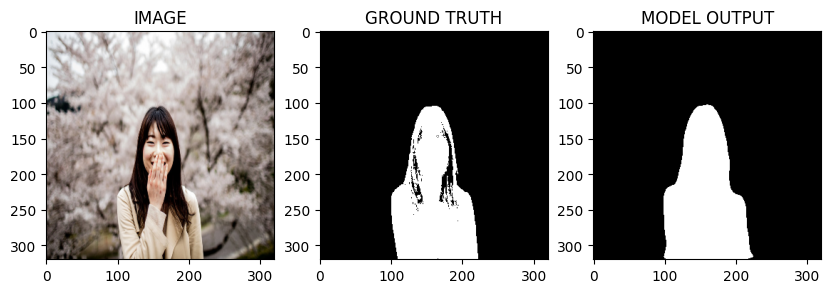

In [57]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))